# **Credit  Card Default Analysis - Notebook**
🧬 THEORY: Setup &Load

Goal: Prepare tools and load data safely.
 We’ll use:
pandas/numpy for data handling


matplotlib/seaborn for plots


scipy/statsmodels for inference (tests, CIs, regressions)


scikit-learn for prediction (logistic regression, random forest)


shap (optional) for feature importance explanations

**What This Code Does**

The purpose of this code block is to prepare the computational environment and load the dataset safely so that later analysis (EDA, inference, and modelling) can be performed correctly.

**1. Importing the required libraries**

The code begins by importing a set of scientific and machine-learning libraries:

pandas/numpy for structured data handling

matplotlib/seaborn for visualisation

scipy/statsmodels for statistical inference (tests, confidence intervals, regressions)

scikit-learn for predictive modelling (logistic regression, random forest)

SHAP for model explainability

A fixed random seed ensures reproducibility, and seaborn provides consistent plot styling.

**2. Loading the dataset**

The dataset is imported using pandas.read_excel() because this file, although named “.csv”, is stored in Excel format. The first row of the dataset is removed because it duplicates header information and should not be treated as a data record.

**3. Cleaning variable names**

Real-world datasets often contain irregular column names (spaces, brackets, symbols).
The code standardises all column names by:

converting them to lowercase

removing brackets, hyphens, and dots

replacing spaces with underscores

This produces clean, valid Python identifiers and prevents errors during analysis.

**4. Converting numeric-looking variables**

Some variables are stored as text (e.g., "20,000" or "45%").
The code attempts to coerce such columns into numeric form after removing characters like commas and percent signs. Columns are only converted if at least 80% of the values are plausibly numeric. This ensures that genuine text columns are not corrupted.

**5. Identifying the target variable**

The code automatically detects the binary outcome variable used for predictive modelling.
Different versions of the dataset name this variable differently ("y" or "default_payment_next_month"), so both are checked.
Once found, the target is converted to integer form (0/1), ensuring compatibility with classification algorithms.

**6. Structural verification**

Finally, the code prints dataset dimensions, the distribution of the target variable, and summary metadata.
This step confirms that data has been loaded and formatted correctly before proceeding to EDA and modelling.

In [1]:
# 0.1 CODE (run)
# (If needed) install once:
# !pip install pandas numpy matplotlib seaborn scipy statsmodels scikit-learn shap openpyxl


import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from pathlib import Path
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, roc_auc_score, roc_curve,
precision_recall_curve, average_precision_score,
confusion_matrix, classification_report)


import shap
np.random.seed(42)
sns.set(style="whitegrid")


# Load
DATA_PATH = Path("default of credit card clients.csv") # put file in same dir or set full path
# The binary inspection suggests this is likely an Excel file, not a CSV.
# We'll try reading it as an Excel file instead.
# If you encounter an error, you might need to install the 'openpyxl' library: !pip install openpyxl
df = pd.read_excel(DATA_PATH)

# Drop the first row, which contains headers
df = df.iloc[1:].copy()


# Clean headers
def clean_col(c):
    c = str(c).strip().lower().replace("(", "").replace(")", "").replace("-", "_")
    c = c.replace(".", "_")
    c = "_".join(c.split())
    return c
df.columns = [clean_col(c) for c in df.columns]


# Coerce numerics where appropriate
df_num = df.copy()
for c in df_num.columns:
    if df_num[c].dtype == object:
        tmp = pd.to_numeric(df_num[c].astype(str).str.replace(",", "").str.replace("%",""), errors="coerce")
        if tmp.notna().mean() > 0.8:
            df_num[c] = tmp


# Detect binary target
target = "y" if "y" in df_num.columns else "default_payment_next_month" if "default_payment_next_month" in df_num.columns else None
assert target is not None, "Target not found (expected 'y' or 'default_payment_next_month')."
df_num[target] = pd.to_numeric(df_num[target], errors="coerce").astype(int)


# Quick info
print(df_num.shape)
print(df_num[target].value_counts(dropna=False))


df_num.info()

(30000, 25)
y
0    23364
1     6636
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 1 to 30000
Data columns (total 25 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   unnamed:_0  30000 non-null  int64
 1   x1          30000 non-null  int64
 2   x2          30000 non-null  int64
 3   x3          30000 non-null  int64
 4   x4          30000 non-null  int64
 5   x5          30000 non-null  int64
 6   x6          30000 non-null  int64
 7   x7          30000 non-null  int64
 8   x8          30000 non-null  int64
 9   x9          30000 non-null  int64
 10  x10         30000 non-null  int64
 11  x11         30000 non-null  int64
 12  x12         30000 non-null  int64
 13  x13         30000 non-null  int64
 14  x14         30000 non-null  int64
 15  x15         30000 non-null  int64
 16  x16         30000 non-null  int64
 17  x17         30000 non-null  int64
 18  x18         30000 non-null  int64
 19  x19  

In [2]:
DATA_PATH = Path("default of credit card clients.csv")
# Read the first few lines of the file in binary mode to avoid encoding issues initially
with open(DATA_PATH, 'rb') as f:
    for i in range(10): # Read first 10 lines
        line = f.readline()
        print(line)

b'\xd0\xcf\x11\xe0\xa1\xb1\x1a\xe1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00>\x00\x03\x00\xfe\xff\t\x00\x06\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00U\x00\x00\x00A*\x00\x00\x00\x00\x00\x00\x00\x10\x00\x00\xfe\xff\xff\xff\x00\x00\x00\x00\xfe\xff\xff\xff\x00\x00\x00\x00\xec)\x00\x00\xed)\x00\x00\xee)\x00\x00\xef)\x00\x00\xf0)\x00\x00\xf1)\x00\x00\xf2)\x00\x00\xf3)\x00\x00\xf4)\x00\x00\xf5)\x00\x00\xf6)\x00\x00\xf7)\x00\x00\xf8)\x00\x00\xf9)\x00\x00\xfa)\x00\x00\xfb)\x00\x00\xfc)\x00\x00\xfd)\x00\x00\xfe)\x00\x00\xff)\x00\x00\x00*\x00\x00\x01*\x00\x00\x02*\x00\x00\x03*\x00\x00\x04*\x00\x00\x05*\x00\x00\x06*\x00\x00\x07*\x00\x00\x08*\x00\x00\t*\x00\x00\n'
b'*\x00\x00\x0b*\x00\x00\x0c*\x00\x00\r*\x00\x00\x0e*\x00\x00\x0f*\x00\x00\x10*\x00\x00\x11*\x00\x00\x12*\x00\x00\x13*\x00\x00\x14*\x00\x00\x15*\x00\x00\x16*\x00\x00\x17*\x00\x00\x18*\x00\x00\x19*\x00\x00\x1a*\x00\x00\x1b*\x00\x00\x1c*\x00\x00\x1d*\x00\x00\x1e*\x00\x00\x1f*\x00\x00 *\x00\x00!*\x00\x00"*\x00\x00#*\x

#**THEORY: Descriptive Statistics**

Analogy: A report card — summarize what we see in this file (not the whole population).

Core concepts:

Statistic vs parameter (sample vs population).

Central tendency & spread: mean ($\bar{x}$), median, variance/SD ($s$), CV ($s/\bar{x}$, unitless), MAD ($\mathrm{median}(|x_i - \mathrm{median}(x)|)$).

Shape: skewness (asymmetry), excess kurtosis (tail heaviness).

Association: Pearson (linear), Spearman (rank/monotone).

Limits: Descriptive ≠ inferential; correlation ≠ causation.


Descriptive Statistics & Data Profiling

**Analogy:**
Think of descriptive statistics like a report card for your dataset.
It summarises what we see in this sample, not the entire population.
It describes, but does not generalise beyond the data.

**1. Statistic vs Parameter**

A statistic is a numerical summary computed from the sample (e.g., the sample mean).

A parameter is the true value in the population (e.g., the population mean).

Since we rarely observe the whole population, we use statistics to estimate parameters.

**2. Central Tendency & Spread**

These describe the typical values and variability in the data.

Central Tendency

Mean (𝑥̄): arithmetic average

Median: middle value, robust to outliers

Spread / Variability

Variance / Standard Deviation (s): how far values spread around the mean

Coefficient of Variation (CV = s / 𝑥̄): unitless measure of relative variability

Median Absolute Deviation (MAD):

MAD
=
median
(
∣
𝑥
𝑖
−
median
(
𝑥
)
∣
)
MAD=median(∣x
i
	​

−median(x)∣)

A robust alternative to standard deviation (less sensitive to outliers)

**3. Shape of the Distribution**

Skewness: measures asymmetry

right-skew = long tail on the right

left-skew = long tail on the left

Excess Kurtosis: measures tail heaviness compared to a normal distribution

high kurtosis = heavy tails (more outliers)

low kurtosis = light tails

**4. Associations Between Variables**

Association does not imply causation.

Correlation Measures

Pearson correlation:

measures linear relationships

sensitive to outliers

Spearman correlation:

measures monotonic (rank-based) relationships

more robust to nonlinearity and outliers

**5. Important Limitations**

Descriptive statistics ≠ inferential statistics
Descriptive statistics only summarise the sample; they do not provide margins of error or generalise to the population.

Correlation ≠ causation
Even a strong association does not prove that one variable causes the other.

,count,mean,std,min,25%,50%,75%,max
unnamed:_0,30000.0,15000.500000,8660.398374,1.0,7500.75,15000.5,22500.25,30000.0
x1,30000.0,167484.322667,129747.661567,10000.0,50000.00,140000.0,240000.00,1000000.0
x2,30000.0,1.603733,0.489129,1.0,1.00,2.0,2.00,2.0
x3,30000.0,1.853133,0.790349,0.0,1.00,2.0,2.00,6.0
x4,30000.0,1.551867,0.521970,0.0,1.00,2.0,2.00,3.0
x5,30000.0,35.485500,9.217904,21.0,28.00,34.0,41.00,79.0
x6,30000.0,-0.016700,1.123802,-2.0,-1.00,0.0,0.00,8.0
x7,30000.0,-0.133767,1.197186,-2.0,-1.00,0.0,0.00,8.0
x8,30000.0,-0.166200,1.196868,-2.0,-1.00,0.0,0.00,8.0
x9,30000.0,-0.220667,1.169139,-2.0,-1.00,0.0,0.00,8.0


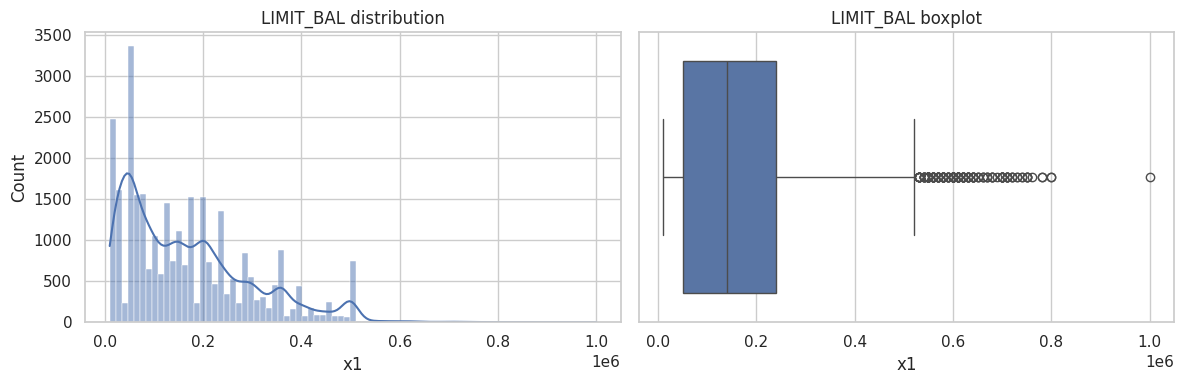

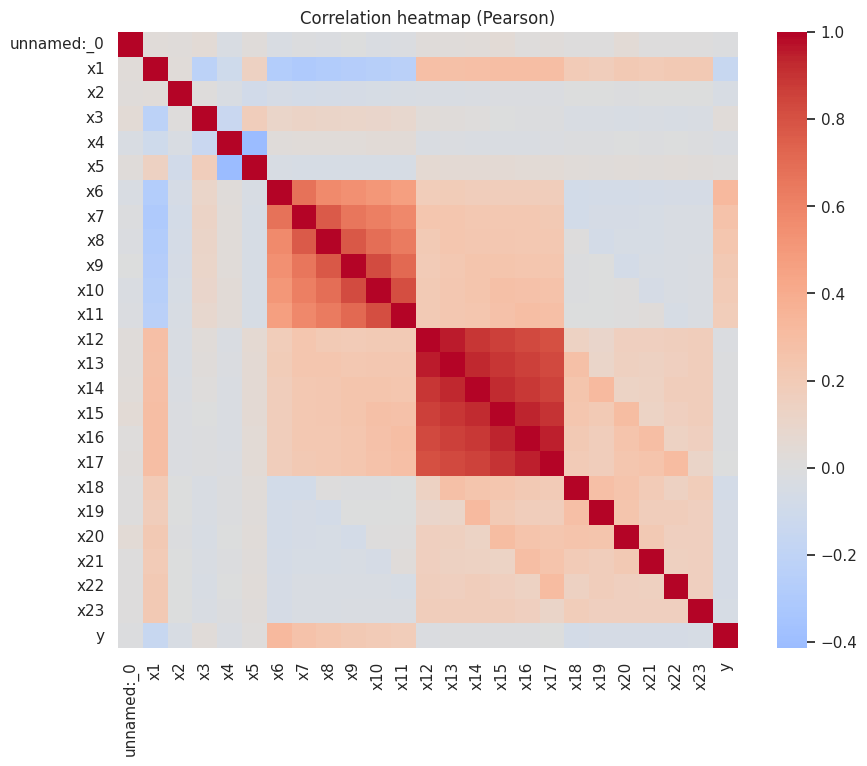

In [3]:
# 1.1 CODE (run)
numeric_cols = df_num.select_dtypes(include=np.number).columns.tolist()
display(df_num[numeric_cols].describe().T)


# Example plots
fig, axes = plt.subplots(1,2, figsize=(12,4))
sns.histplot(df_num["x1"], kde=True, ax=axes[0]); axes[0].set_title("LIMIT_BAL distribution")
sns.boxplot(x=df_num["x1"], ax=axes[1]); axes[1].set_title("LIMIT_BAL boxplot")
plt.tight_layout(); plt.show()


plt.figure(figsize=(10,8))
corr = df_num[numeric_cols].corr(method="pearson")
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Correlation heatmap (Pearson)")
plt.show()

#**THEORY: Power tools (CV, MAD, skewness)**

Power Tools — THEORY

These descriptive tools give deeper insight into variability, robustness, and distribution shape.

1. Coefficient of Variation (CV)
CV
=
𝑠
𝑥
ˉ
CV=
x
ˉ
s
	​


CV is unitless, which makes it useful for comparing variability across features measured in different units (e.g., income vs age vs credit limit).

A higher CV means higher variability relative to the mean.

2. Median Absolute Deviation (MAD)
MAD
=
median
(
∣
𝑥
𝑖
−
median
(
𝑥
)
∣
)
MAD=median(∣x
i
	​

−median(x)∣)

MAD is robust because outliers do not heavily influence it.

Useful when the data contain extreme values that distort standard deviation.

**3. Skewness**

Right-skew (positive skew):

Long tail to the right

Mean > Median

Left-skew (negative skew):

Long tail to the left

Mean < Median

Skewness describes asymmetry and helps focus attention on data cleaning (e.g., transformations).

**4. Excess Kurtosis**

Measures tail heaviness relative to the normal distribution.

Excess kurtosis > 0: heavy tails, more extreme values

Excess kurtosis < 0: light tails, fewer extreme values

High kurtosis suggests the presence of potentially influential observations.

In [4]:
# 1.2 CODE (run)
from scipy import stats


def coef_var(x): return np.nanstd(x, ddof=1) / np.nanmean(x)
def mad(x):
    med = np.nanmedian(x)
    return np.nanmedian(np.abs(x - med))


for col in ["x1", "x5"]:
    x = df_num[col].dropna().values
    print(f"\n[{col}]")
    print("Mean:", np.nanmean(x), "SD:", np.nanstd(x, ddof=1), "CV:", coef_var(x))
    print("Median:", np.nanmedian(x), "MAD:", mad(x))
    print("Skewness:", stats.skew(x, nan_policy="omit"))
    print("Excess kurtosis:", stats.kurtosis(x, fisher=True, nan_policy="omit"))


[x1]
Mean: 167484.32266666667 SD: 129747.66156720239 CV: 0.7746854123500911
Median: 140000.0 MAD: 90000.0
Skewness: 0.9928173164820109
Excess kurtosis: 0.5359735300865474

[x5]
Mean: 35.4855 SD: 9.217904068090188 CV: 0.2597653708723334
Median: 34.0 MAD: 6.0
Skewness: 0.7322092559811012
Excess kurtosis: 0.044096001350454994


# **Monotonicity Across Months — THEORY**



*Many financial variables in the credit dataset (e.g.,
bill_amt1–6, pay_amt1–6, past payment statuses) represent time-ordered sequences. A useful descriptive question is whether these sequences show monotonic patterns—for example, whether a customer’s bill amounts consistently trend upward or downward over the six-month period.

To detect such patterns, we can correlate each feature sequence with a time index (1 to 6). Because real-world financial data rarely change in strictly linear ways, we use Spearman correlation, which measures rank-based (monotonic) relationships. A strong positive Spearman coefficient suggests an upward trend over time; a strong negative coefficient indicates a downward trend.

This is not only descriptive—it can also guide feature engineering.
For example, if bill amounts show a clear monotonic trend, we could create features such as:


* overall trend (positive/negative)
* magnitude of the trend




*  volatility around the tend



These engineered features often improve predictive performance in credit-risk models.

,bill_monotone,pay_monotone
count,28773.000000,28350.000000
mean,-0.113307,-0.235619
std,0.692437,0.493500
min,-1.000000,-1.000000
25%,-0.771429,-0.654654
50%,-0.257143,-0.314286
75%,0.555492,0.115954
max,1.000000,1.000000


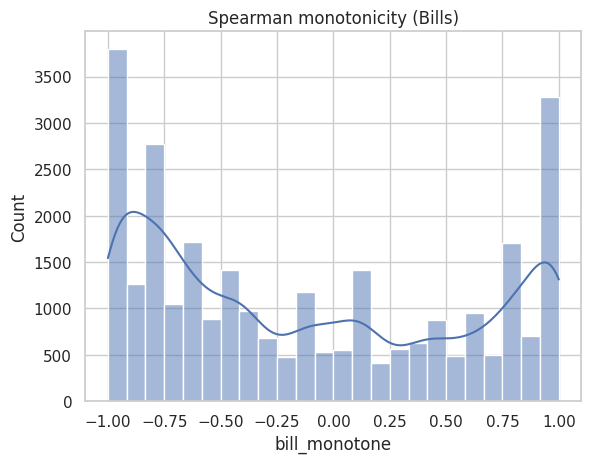

In [5]:
# 1.3 CODE (run)
# Identify the columns for bill and pay amounts based on the data
# Assuming x12-x17 are bill amounts and x18-x23 are pay amounts based on data description
bill_cols = ['x12', 'x13', 'x14', 'x15', 'x16', 'x17'] # Corresponds to BILL_AMT1..6
pay_cols  = ['x18', 'x19', 'x20', 'x21', 'x22', 'x23'] # Corresponds to PAY_AMT1..6


def monotone_score(row, cols):
    y = row[cols].values.astype(float)
    # Ensure there are at least 2 non-NaN values and not all values are the same for spearmanr
    valid_y = y[~np.isnan(y)]
    if len(valid_y) < 2 or np.all(valid_y == valid_y[0]):
        return np.nan
    t = np.arange(1, len(cols)+1)
    return stats.spearmanr(t, valid_y, nan_policy='omit').correlation


df_num["bill_monotone"] = df_num.apply(lambda r: monotone_score(r, bill_cols), axis=1)
df_num["pay_monotone"] = df_num.apply(lambda r: monotone_score(r, pay_cols), axis=1)


display(df_num[["bill_monotone","pay_monotone"]].describe())


sns.histplot(df_num["bill_monotone"], kde=True); plt.title("Spearman monotonicity (Bills)"); plt.show()

# **Inferential Statistics**

Sampling & CIs:

Sampling distribution: statistics vary across repeated samples.

CLT: for large ($n$), $\bar{x} \approx \text{Normal}$;  
$SE = \dfrac{s}{\sqrt{n}}$

95% CI: an algorithm that covers $\mu$ approximately 95% of the time.  
It is **not** “a 95% chance that this specific CI contains $\mu$.”


#Sampling & Confidence Intervals — THEORY
**1. Sampling and Sampling Distributions**

When we take a sample from a population, any statistic we compute (mean, median, proportion) will vary from sample to sample.
This variability forms the sampling distribution of the statistic.
Understanding this distribution allows us to quantify uncertainty.

**2. Central Limit Theorem (CLT)**

For a sufficiently large sample size (n), the sampling distribution of the sample mean

𝑥
ˉ
x
ˉ

is approximately Normal, regardless of the population’s original distribution.

The standard uncertainty of the sample mean is measured by the Standard Error (SE):

𝑆
𝐸
=
𝑠
𝑛
SE=
n
	​

s
	​


where
𝑠
s is the sample standard deviation.

The CLT justifies constructing confidence intervals even when the raw data are skewed or non-normal.

**3. Interpreting a 95% Confidence Interval**

A 95% Confidence Interval (CI) is a procedure that, if repeated many times on new samples, will contain the true population mean
𝜇
μ about 95% of the time.

Important clarification:

A 95% CI means “this method captures
𝜇
μ 95% of the time.”

It does not mean “there is a 95% probability that this specific interval contains
𝜇
μ.”

Once the interval is computed,
𝜇
μ is fixed — either inside or outside the interval.
The uncertainty lies in the sampling process, not in the parameter.

In [6]:
# 2.1 CODE — Bootstrap CIs for mean LIMIT_BAL by default class


def bootstrap_ci(x, B=2000, alpha=0.05, func=np.mean, seed=42):
    rng = np.random.default_rng(seed)
    x = x[~np.isnan(x)]
    boots = [func(rng.choice(x, size=len(x), replace=True)) for _ in range(B)]
    lo, hi = np.quantile(boots, [alpha/2, 1-alpha/2])
    return np.mean(x), (lo, hi)


for val in [0,1]:
    x = df_num.loc[df_num[target]==val, "x1"].astype(float).values
    m, (lo, hi) = bootstrap_ci(x)
    print(f"default={val}: mean={m:,.1f}, 95% CI=({lo:,.1f}, {hi:,.1f})")

default=0: mean=178,099.7, 95% CI=(176,377.6, 179,765.2)
default=1: mean=130,109.7, 95% CI=(127,426.2, 132,872.2)


#**THEORY: Hypothesis testing**

Hypothesis testing:

State ($H_0 / H_1$), pick $\alpha$, compute a test statistic, get the p-value under $H_0$, decide, and report effect size.

Type I ($\alpha$): false positive; Type II ($\beta$): false negative; power improves with sample size ($n$).

Welch t-test (unequal variances) vs Mann–Whitney U test (rank-based).

$\chi^2$ test of independence for categorical association (check expected counts).

Effect sizes: Cohen's $d$ (for means), Cramer's $V$ (for contingency tables).


**Hypothesis Testing — THEORY**

Hypothesis testing provides a structured framework for deciding whether an observed effect in a sample is large enough to be unlikely under a “no-effect” assumption.

**1. The General Procedure**

State the hypotheses

Null hypothesis (H₀): no effect, no difference, or no association

Alternative hypothesis (H₁): the effect or difference of interest

Choose a significance level (α)
Common choices: 0.05 or 0.01.
This determines the allowed probability of a Type I error.

Compute a test statistic
A numerical summary (t, z, χ², U, etc.) measuring how far the sample result is from what H₀ predicts.

Obtain the p-value under H₀
The p-value is the probability of observing a test statistic as extreme or more extreme than the one obtained, given that H₀ is true.

Decision rule

If p ≤ α → reject H₀

If p > α → fail to reject H₀

Report effect size
Hypothesis tests alone do not quantify how big or practically meaningful the effect is, so effect sizes are required for interpretation.

**2. Error Types and Power**

Type I error (α): false positive — rejecting H₀ when it is actually true.

Type II error (β): false negative — failing to reject H₀ when H₁ is true.

Power (1 − β): probability of detecting a true effect.

Power increases with larger sample size (n), larger effect size, and lower variability.

**3. Common Tests**
Welch’s t-test

Compares means of two groups

Assumes approximate normality

Does not assume equal variances (safer default than Student t-test)

Mann–Whitney U test

Rank-based, nonparametric

Tests for differences in distributions

Useful when data are skewed or contain outliers

χ² Test of Independence

For association between two categorical variables

Uses a contingency table

Requires adequate expected cell counts (rule of thumb: ≥5 per cell)

**4. Effect Sizes**

Hypothesis tests alone do not convey practical importance.
Effect sizes quantify the magnitude of differences or associations.

Cohen’s d (for difference in means)

𝑑
=
𝑥
ˉ
1
−
𝑥
ˉ
2
𝑠
pooled
d=
s
pooled
	​

x
ˉ
1
	​

−
x
ˉ
2


Interprets group separation in standard deviation units.

Cramer’s V (for categorical association)

𝑉
=
𝜒
2
𝑛
(
𝑘
−
1
)
V=
n(k−1)
χ
2
Where
𝑘
k is the smaller dimension of the table.
Interprets strength of association (0 = none, 1 = perfect).

In [7]:
# 2.2 CODE — t/MW tests, χ², effect sizes
# Mean difference LIMIT_BAL by default
g0 = df_num.loc[df_num[target]==0, "x1"].dropna()
g1 = df_num.loc[df_num[target]==1, "x1"].dropna()


# Welch t-test
t_stat, p_t = stats.ttest_ind(g0, g1, equal_var=False)
# Mann-Whitney
u_stat, p_u = stats.mannwhitneyu(g0, g1, alternative="two-sided")


def cohens_d(a,b):
    s1, s2 = np.nanvar(a, ddof=1), np.nanvar(b, ddof=1)
    n1, n2 = len(a), len(b)
    s_pooled = np.sqrt(((n1-1)*s1+(n2-1)*s2)/(n1+n2-2))
    return (np.nanmean(a)-np.nanmean(b))/s_pooled


print("Welch t-test p:", p_t, " | Mann-Whitney p:", p_u, " | Cohen's d:", cohens_d(g0, g1))


# Chi-square: EDUCATION vs default (if present)
if "x3" in df_num.columns: # Assuming 'x3' is the cleaned 'EDUCATION' column
    ct = pd.crosstab(df_num["x3"], df_num[target])
    chi2, p_chi, dof, exp = stats.chi2_contingency(ct)
    cramers_v = np.sqrt(chi2 / (ct.values.sum() * (min(ct.shape)-1)))
    print("Chi-square p:", p_chi, " | Cramer's V:", cramers_v)

Welch t-test p: 3.364100245511469e-178  | Mann-Whitney p: 1.2255485818223303e-189  | Cohen's d: 0.37430331962716473
Chi-square p: 1.2332626245415605e-32  | Cramer's V: 0.07376009713252163


# **Predictive Statistics (ML)**

**THEORY: Predictive setup**

Goal: Predict y for new cases.
Separate model performance (AUC/PR) from business decision (threshold).


Use train/test split with stratification; compare to majority baseline.

#Predictive Modelling — THEORY
**1. Goal of Predictive Modelling**

The objective is to learn a statistical or machine-learning model that can predict the target variable (y) for new, unseen cases.
The focus is on generalisation, not memorising the training data.

**2. Separate Model Performance from Business Decisions**

A key principle is to separate model quality from the decision threshold used in practice.

Model Performance

Model performance measures how well the model ranks or scores cases.
Common metrics:

AUC-ROC (Area Under ROC Curve):
Measures the model’s ability to separate positives from negatives across all thresholds.

PR-AUC (Precision–Recall AUC):
More informative when the positive class is rare (class imbalance).
Focuses on precision (false positives) and recall (false negatives).

These metrics evaluate the model independently of any specific cutoff.

Business Decision / Threshold

Operational decisions often require converting predicted probabilities into classes using a threshold (e.g., approving loans, flagging risk).
The threshold depends on:

cost of false positives vs false negatives

business rules

risk appetite

The threshold is not part of model training; it is a policy choice.

**3. Train/Test Split**

To estimate generalisation performance, the data must be split into:

Training set: used to fit the model

Test set: used only at the end to evaluate performance on unseen data

Stratification ensures the class proportions are preserved in both splits.
This is essential when the target class is imbalanced.

Example:

train_test_split(..., stratify=y)

**4. Baseline Comparison**

Every model should be compared to a simple baseline, typically:

Majority class model (always predict the most frequent class)

This gives baseline accuracy, baseline precision/recall, and baseline PR-AUC.

A model only has value if it outperforms the baseline, especially on recall, PR-AUC, or AUC.

In [8]:
# 3.1 CODE — Split + baseline
y = df_num[target].astype(int)
X = df_num.drop(columns=[target])


# Use numeric features; (encode categoricals later if needed)
X = X.select_dtypes(include=np.number).fillna(X.mean(numeric_only=True))


X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.2, stratify=y, random_state=42
)


majority = max((y_test==0).mean(), (y_test==1).mean())
print(f"Majority baseline accuracy: {majority:.3f}")

Majority baseline accuracy: 0.779


#**THEORY: Models & metrics**

Models: logistic regression (linear log-odds) vs random forest (nonlinear).
 Metrics: Accuracy (threshold-dependent), ROC-AUC (ranking), PR-AUC (class imbalance).
 Interpretation: coefficients (logit) vs SHAP (RF/global+local).


#Models & Interpretation — THEORY
**1. Model Types**
Logistic Regression

A linear model for binary outcomes

Models the log-odds of the target:

log
⁡
𝑝
1
−
𝑝
=
𝛽
0
+
𝛽
1
𝑥
1
+
⋯
+
𝛽
𝑘
𝑥
𝑘
log
1−p
p
	​

=β
0
	​

+β
1
	​

x
1
	​

+⋯+β
k
	​

x
k
	​


Assumes linear relationships between predictors and log-odds

Interpretable coefficients: each
𝛽
𝑖
β
i
	​

 represents the change in log-odds of the outcome per unit increase in
𝑥
𝑖
x
i
	​


Random Forest

A nonlinear, ensemble tree-based model

Captures complex interactions and nonlinear patterns

Less interpretable by default, but often more flexible than logistic regression

**2. Performance Metrics**
Threshold-Dependent

Accuracy: fraction of correct predictions using a chosen probability threshold

Sensitive to class imbalance

Threshold-Independent

ROC-AUC (Area Under ROC Curve):
Measures ranking ability across all thresholds; higher = better separation of positive vs negative cases

PR-AUC (Precision–Recall AUC):
More informative for imbalanced datasets; emphasizes correct identification of the positive class

**3. Interpretation of Results**
Logistic Regression

Coefficients (
𝛽
𝑖
β
i
	​

) are interpretable as log-odds effects

Can compute odds ratios (
𝑒
𝛽
𝑖
e
β
i
	​

) for intuitive interpretation

Random Forest

Use SHAP values for explanation:

Global: feature importance across the dataset

Local: contribution of each feature for individual predictions

SHAP makes complex, nonlinear models interpretable while preserving predictive power


[Logistic] ACC=0.809 ROC-AUC=0.709 PR-AUC=0.494
              precision    recall  f1-score   support

           0      0.820     0.968     0.888      4673
           1      0.691     0.249     0.367      1327

    accuracy                          0.809      6000
   macro avg      0.755     0.609     0.627      6000
weighted avg      0.791     0.809     0.773      6000


[RandomForest] ACC=0.815 ROC-AUC=0.762 PR-AUC=0.541
              precision    recall  f1-score   support

           0      0.839     0.942     0.888      4673
           1      0.642     0.364     0.465      1327

    accuracy                          0.815      6000
   macro avg      0.741     0.653     0.676      6000
weighted avg      0.796     0.815     0.794      6000



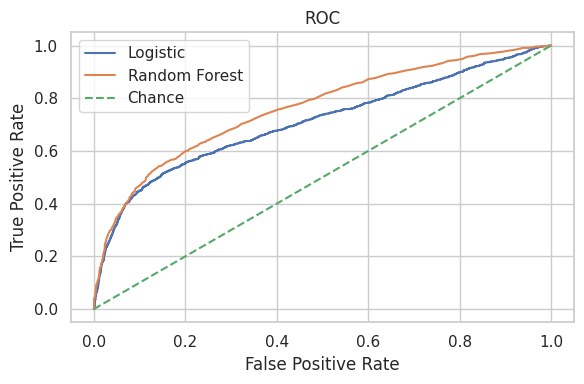

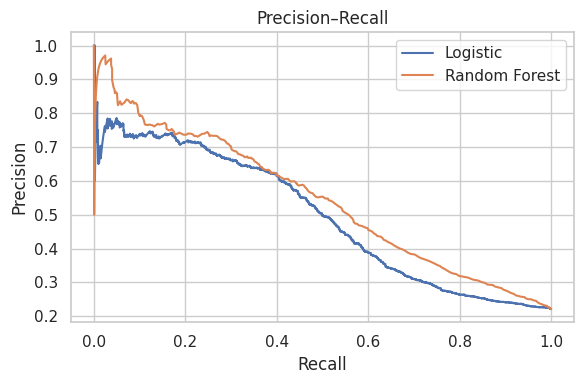

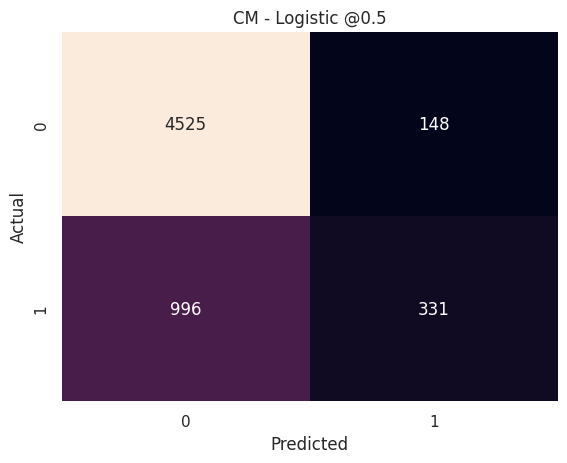

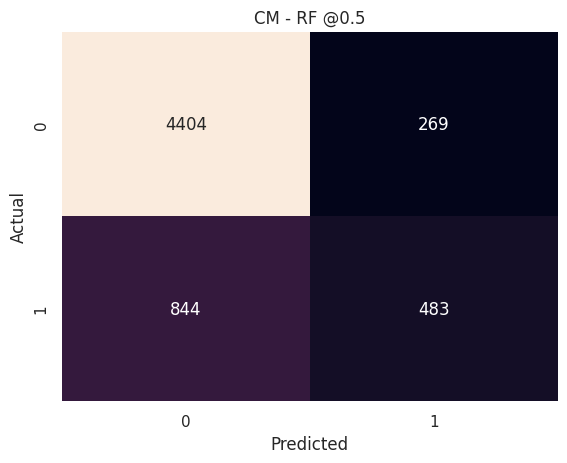

In [9]:
from sklearn.impute import SimpleImputer

# Logistic Regression
logit = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")), # Add imputer to handle NaNs
    ("scaler", StandardScaler(with_mean=True)),
    ("clf", LogisticRegression(max_iter=2000, solver="liblinear"))
]).fit(X_train, y_train)
proba_log = logit.predict_proba(X_test)[:,1]
pred_log = (proba_log >= 0.5).astype(int)

# Random Forest
rf = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")), # Add imputer to handle NaNs
    ("clf", RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1))
]).fit(X_train, y_train)
proba_rf = rf.predict_proba(X_test)[:,1]
pred_rf = (proba_rf >= 0.5).astype(int)

def eval_model(name, y_true, pred, proba):
    acc = accuracy_score(y_true, pred)
    roc = roc_auc_score(y_true, proba)
    pr  = average_precision_score(y_true, proba)
    print(f"\n[{name}] ACC={acc:.3f} ROC-AUC={roc:.3f} PR-AUC={pr:.3f}")
    print(classification_report(y_true, pred, digits=3))
    return acc, roc, pr

eval_model("Logistic", y_test, pred_log, proba_log)
eval_model("RandomForest", y_test, pred_rf, proba_rf)

# ROC
fpr_l, tpr_l, _ = roc_curve(y_test, proba_log)
fpr_r, tpr_r, _ = roc_curve(y_test, proba_rf)
plt.figure(figsize=(6,4))
plt.plot(fpr_l, tpr_l, label="Logistic")
plt.plot(fpr_r, tpr_r, label="Random Forest")
plt.plot([0,1],[0,1],"--",label="Chance")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate"); plt.title("ROC"); plt.legend()
plt.tight_layout(); plt.show()

# Precision–Recall
prec_l, rec_l, _ = precision_recall_curve(y_test, proba_log)
prec_r, rec_r, _ = precision_recall_curve(y_test, proba_rf)
plt.figure(figsize=(6,4))
plt.plot(rec_l, prec_l, label="Logistic")
plt.plot(rec_r, prec_r, label="Random Forest")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Precision–Recall"); plt.legend()
plt.tight_layout(); plt.show()

# Confusion matrices at 0.5
def plot_cm(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cbar=False)
    plt.title(title); plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.show()

plot_cm(y_test, pred_log, "CM - Logistic @0.5")
plot_cm(y_test, pred_rf,  "CM - RF @0.5")

## **3.3 CODE — Threshold by Youden’s J**

**Threshold tuning:** 0.5 is arbitrary. Choose a threshold that aligns with costs (missed default vs false alarm). Youden’s J maximizes TPR−FPR; business settings may prefer other tradeoffs.
 Calibration: Scores should reflect probabilities for fair decisions.

Threshold Tuning & Calibration — THEORY
**1. Threshold Selection**

Default threshold of 0.5 is arbitrary and assumes equal cost for false positives and false negatives.

In practice, business costs differ:

Missed default (false negative): lost revenue or risk exposure

False alarm (false positive): unnecessary interventions, wasted resources

Thresholds should therefore be aligned with business objectives.

Common Approaches

Youden’s J statistic:

𝐽
=
TPR
−
FPR
J=TPR−FPR

Maximizes the difference between true positive rate and false positive rate.

Cost-based threshold:
Choose a threshold that minimizes expected monetary loss or maximizes expected utility.

Custom trade-offs:
For highly imbalanced datasets or critical applications, thresholds may favor recall over precision or vice versa.

**2. Calibration of Predicted Probabilities**

Predicted probabilities should reflect true likelihoods of the event.

Poorly calibrated scores can lead to unfair or costly decisions, even if the model has high discrimination (ROC-AUC).

Calibration Techniques

Platt scaling or isotonic regression can adjust predicted probabilities to improve reliability.

Well-calibrated probabilities allow consistent decision-making across thresholds and risk levels.

Best threshold (Youden): 0.3233333333333333

[RF @Youden] ACC=0.789 ROC-AUC=0.762 PR-AUC=0.541
              precision    recall  f1-score   support

           0      0.868     0.859     0.864      4673
           1      0.521     0.540     0.531      1327

    accuracy                          0.789      6000
   macro avg      0.695     0.700     0.697      6000
weighted avg      0.791     0.789     0.790      6000



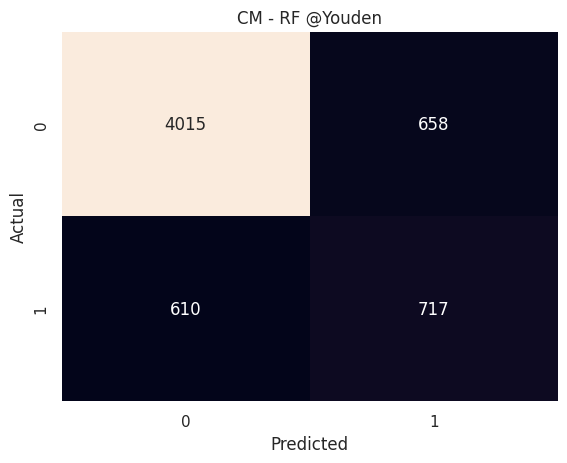

In [10]:
fpr, tpr, thr = roc_curve(y_test, proba_rf)
youden = tpr - fpr
best_t = thr[np.argmax(youden)]
print("Best threshold (Youden):", best_t)

pred_rf_best = (proba_rf >= best_t).astype(int)
eval_model("RF @Youden", y_test, pred_rf_best, proba_rf)
plot_cm(y_test, pred_rf_best, "CM - RF @Youden")

## **3.4 CODE — Coefficients + SHAP**

#Model Interpretability — Logistic Coefficients & SHAP (Theory)
**1. Logistic Regression Coefficients**

The code extracts logit model coefficients after all preprocessing (imputation, scaling) has been applied to the test set.

coef_ represents the effect of each predictor on the log-odds of the target variable.

By sorting by absolute value (abs_coef), we identify the top 15 most influential features.

Interpretation:

Sign (+/-): direction of effect

Positive → increases probability of default

Negative → decreases probability of default

Magnitude: relative strength of influence on the log-odds

**2. Random Forest Feature Attribution (SHAP)**

Random Forest is nonlinear, so we use SHAP values to interpret feature contributions.

Steps:

Apply the same preprocessing as in the RF pipeline (imputation) to the test data.

Extract feature names after imputation for correct labeling.

Use shap.TreeExplainer to compute SHAP values for the positive class.

Visualize the SHAP summary plot, which shows:

Global feature importance: which features most influence predictions overall

Direction of effect: red → higher feature values increase risk, blue → decrease risk

SHAP allows us to interpret each individual prediction and understand which features drive the model’s decisions.

**3. Key Points**

Logistic regression: linear, interpretable coefficients; useful for understanding magnitude and direction.

Random forest: nonlinear, flexible; SHAP provides robust global and local interpretability.

Both approaches complement each other:

Logistic regression → clear, simple interpretation

Random forest → captures complex patterns, explained via SHAP

Interpretability:
Logit coefficients: sign & magnitude in log-odds (after scaling).


SHAP (trees): robust feature attributions (global & per-example).


In [1]:
# Logistic coefficients (top 15 by |coef|)
# Apply the same transformations to X_test as were applied in the logit pipeline
# Check if logit and rf are defined
if 'logit' not in locals() or 'rf' not in locals():
    print("Please run the preceding cells to define 'logit' and 'rf' models.")
else:
    X_test_transformed_log = logit.named_steps["imputer"].transform(X_test)
    X_test_transformed_log = logit.named_steps["scaler"].transform(X_test_transformed_log)

    # Get the feature names after imputation
    feature_names_log = logit.named_steps["imputer"].get_feature_names_out(X_test.columns)

    coef = logit.named_steps["clf"].coef_.ravel()
    coef_df = pd.DataFrame({"feature": feature_names_log, "coef": coef})
    coef_df["abs_coef"] = coef_df["coef"].abs()
    display(coef_df.sort_values("abs_coef", ascending=False).head(15).drop(columns="abs_coef"))

    # SHAP summary (Random Forest)
    # Apply the same transformations to X_test as were applied in the rf pipeline
    X_test_transformed_rf = rf.named_steps["imputer"].transform(X_test)
    # Note: RandomForestClassifier does not require scaling, but if other models did,
    # you would apply their respective scalers here.

    # Use the correct feature names after imputation for the SHAP plot
    feature_names_rf = rf.named_steps["imputer"].get_feature_names_out(X_test.columns)
    explainer = shap.TreeExplainer(rf.named_steps["clf"])
    shap_values = explainer.shap_values(X_test_transformed_rf)[1]
    shap.summary_plot(shap_values, pd.DataFrame(X_test_transformed_rf, columns=feature_names_rf), show=False); plt.title("SHAP summary (RF)"); plt.show()

Please run the preceding cells to define 'logit' and 'rf' models.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#**Causal Inference (Intro, carefully)**



**Define treatment & confounders**

Aim: Estimate a causal effect under assumptions using observational data.
 We need to name assumptions:
Unconfoundedness (no hidden confounders)


Overlap/positivity (both groups possible at each covariate pattern)


SUTVA (no interference, well-defined treatment)
 We’ll define a “treatment” and adjust via propensity scores to estimate an ATE by IPW. Results are sensitivity-prone and for learning, not policy.


#Causal Analysis — Example Treatment Preparation (Theory)
**1. Defining a Treatment**

In causal inference, we define a “treatment” variable representing exposure to some condition.

Here, the treatment is high credit limit, defined as:

treat
=
{
1

if credit limit
≥
200,000


0

otherwise
treat={
1
0
	​

if credit limit ≥200,000
otherwise
	​


This binary variable allows us to compare outcomes (default vs no default) as if treatment was randomly assigned after adjustment for confounders.

**2. Identifying Confounders**

Confounders are variables that influence both treatment and outcome.

Candidate confounders include:

Demographics: age (x5), sex (x2), education (x3), marriage (x4)

Financial history: bill amounts (x12–x17), past payments (x18–x23)

Only columns present in the dataset are retained for analysis.

**3. Data Cleaning**

Rows with missing values in treatment, outcome, or confounders are dropped.

This ensures that subsequent causal analyses (e.g., propensity score methods) are performed on complete cases, avoiding biases from missing data.

**4. Outcome Variable**

The outcome (target) is converted to integer type for consistency in causal models.

**5. Purpose**

After this preprocessing, df_causal contains:

The binary treatment variable

The outcome variable

A set of confounders

This dataset is ready for causal effect estimation (e.g., propensity score weighting, matching, or regression adjustment).

In [3]:
# Example treatment: high credit limit
# Check if df_num is defined
if 'df_num' not in locals():
    print("df_num is not defined. Please run the preceding cells to load and prepare the data.")
else:
    df_causal = df_num.copy()
    # Assuming 'x1' is the credit limit column
    df_causal["treat"] = (df_causal["x1"] >= 200000).astype(int)

    # Candidate confounders (keep only those present and mapped to 'x' columns)
    # Using the columns identified in the descriptive statistics section.
    # x5=age, x2=sex, x3=education, x4=marriage
    # x12-x17 are bill amounts
    # x18-x23 are pay amounts
    base_cols = ['x5', 'x2', 'x3', 'x4']
    bill_cols = ['x12', 'x13', 'x14', 'x15', 'x16', 'x17'] # Corresponds to BILL_AMT1..6
    pay_cols  = ['x18', 'x19', 'x20', 'x21', 'x22', 'x23'] # Corresponds to PAY_AMT1..6

    confounder_candidates = base_cols + bill_cols + pay_cols

    # Filter confounders to include only those present in df_causal columns
    confounders = [c for c in confounder_candidates if c in df_causal.columns]


    # Drop rows with missing values in target, treatment, or confounders
    cols_to_check_na = [target, "treat"] + confounders
    df_causal = df_causal.dropna(subset=cols_to_check_na).copy()


    df_causal[target] = df_causal[target].astype(int)

    display(len(df_causal), df_causal.head(2))

df_num is not defined. Please run the preceding cells to load and prepare the data.


#**PS model + overlap plot**

Propensity score (PS): (p(x)=P(\text{treat}=1|X=x)).

 Overlap check: Without common support, IPW explodes and inference fails.

#Causal Inference — Propensity Scores & Overlap (Theory)
**1. Propensity Score (PS) Modeling**

A propensity score is the probability of receiving the treatment given a set of observed confounders:

𝑃
𝑆
(
𝑥
)
=
𝑃
(
treat
=
1
∣
𝑋
=
𝑥
)
PS(x)=P(treat=1∣X=x)

Here, a logistic regression (smf.logit) is used to model treatment assignment based on all valid confounders.

The predicted values (ps) represent each individual’s likelihood of being in the treated group, conditional on observed covariates.

**2. Overlap / Common Support**

A key assumption for causal inference is overlap (or positivity):
Every subject has a nonzero probability of receiving either treatment.

The overlap plot visualizes the distribution of propensity scores for treated and control groups:

Treated density: distribution of PS among those receiving treatment

Control density: distribution of PS among those not receiving treatment

Good overlap indicates that treated and control groups are comparable; poor overlap may indicate regions where causal estimates are unreliable.

**3. Interpretation**

The PS values can be used for:

Matching: pair treated and control subjects with similar PS

Stratification: divide PS into bins to compare outcomes

Inverse Probability Weighting (IPW): weight subjects by the inverse of PS or 1−PS to estimate the average treatment effect

Displaying descriptive statistics (df_causal["ps"].describe()) helps check the range, mean, and spread of propensity scores, which informs the quality of overlap.

**4. Purpose**

This step ensures that causal effect estimation is adjusted for observed confounders and that treatment and control groups are comparable in terms of their baseline covariates.

In [4]:
# PS model + overlap plot
# Check if confounders and df_causal are defined
if 'confounders' not in locals() or 'df_causal' not in locals():
    print("confounders or df_causal are not defined. Please run the preceding cells.")
else:
    # Ensure confounders used in the formula are actually in the dataframe
    valid_confounders = [c for c in confounders if c in df_causal.columns]
    if not valid_confounders:
        print("No valid confounders found in the dataframe to build the PS model.")
    else:
        form = "treat ~ " + " + ".join(valid_confounders)
        try:
            ps_model = smf.logit(formula=form, data=df_causal).fit(disp=False)
            df_causal["ps"] = ps_model.predict(df_causal)

            sns.kdeplot(df_causal.loc[df_causal["treat"]==1, "ps"], label="Treated")
            sns.kdeplot(df_causal.loc[df_causal["treat"]==0, "ps"], label="Control")
            plt.title("Propensity Score Overlap")
            plt.xlabel("Propensity Score")
            plt.ylabel("Density")
            plt.legend()
            plt.show()

            display(df_causal["ps"].describe())
        except Exception as e:
            print(f"An error occurred during PS model fitting or plotting: {e}")

confounders or df_causal are not defined. Please run the preceding cells.


# **IPW estimate**

IPW ATE:

\[
\text{ATE} = \mathbb{E}\left[ \frac{T Y}{p(X)} - \frac{(1-T) Y}{1-p(X)} \right]
\]

Weights can blow up when $p(X)$ is near 0 or 1 ⇒ trim or reconsider the model.  
Interpret results **with assumptions clearly stated**.


#Causal Inference — IPW and ATE (Theory)
**1. Inverse Probability Weighting (IPW)**

IPW is a method to estimate causal effects from observational data by reweighting individuals according to their propensity scores.

The goal is to create a pseudo-population in which treatment assignment is independent of observed confounders.

Weights are calculated as:

𝑤
𝑖
=
{
1
𝑃
𝑆
𝑖

if treated


1
1
−
𝑃
𝑆
𝑖

if control
w
i
	​

={
PS
i
	​

1
	​

1−PS
i
	​

1

if treated
if control
	​


Subjects with a low probability of receiving their observed treatment get higher weight, correcting for imbalance in covariates.

**2. Trimming Extreme Weights**

Extremely small or large propensity scores produce unstable, very large weights, which inflate variance.

A common practice is trimming at the 1st and 99th percentiles, which stabilizes the estimate while retaining most observations.

**3. Estimating the Average Treatment Effect (ATE)**

The ATE measures the expected difference in outcomes if everyone were treated versus if everyone were untreated.

ATE
=
Weighted mean of
𝑌
 for treated
−
Weighted mean of
𝑌
 for control
ATE=Weighted mean of Y for treated−Weighted mean of Y for control

In code:

w_t = weights for treated

w_c = weights for control

np.average computes weighted means for both groups

Difference gives the IPW estimate of the causal effect

Interpretation:
A positive ATE indicates that the treatment (high credit limit) increases the probability of default; a negative ATE indicates a protective effect.

**4. Effective Sample Size (ESS)**

Weighted analyses reduce the effective sample size, especially if weights vary widely.

ESS is calculated separately for treated and control groups:

ESS
=
(
∑
𝑤
𝑖
)
2
∑
𝑤
𝑖
2
ESS=
∑w
i
2
	​

(∑w
i
	​

)
2
	​


ESS helps assess the reliability of the weighted estimate; very low ESS suggests unstable results.

**5. Purpose**

IPW allows us to estimate the causal effect of high credit limit on default probability adjusting for confounders, using observational data.

Combined with the propensity score overlap check, it supports robust causal inference under the standard assumptions:

Unconfoundedness

Positivity / overlap

SUTVA (no interference)

In [5]:
# IPW estimate
# Check if df_causal and target are defined
if 'df_causal' not in locals() or target not in df_causal.columns or "ps" not in df_causal.columns:
    print("df_causal, target, or propensity scores ('ps') are not defined. Please run the preceding cells.")
else:
    # Implement trimming of propensity scores to avoid extreme weights
    # A common practice is to trim at the 1st and 99th percentiles
    ps_trimmed = df_causal["ps"].clip(lower=df_causal["ps"].quantile(0.01), upper=df_causal["ps"].quantile(0.99))

    eps = 1e-6 # Added small epsilon to avoid division by zero

    # Calculate IP weights using trimmed propensity scores
    w_t = df_causal["treat"] / (ps_trimmed + eps)
    w_c = (1 - df_causal["treat"]) / (1 - ps_trimmed + eps)

    y_out = df_causal[target].values
    tmask = df_causal["treat"].values.astype(bool)

    # Calculate ATE using weighted means
    ate_ipw = np.average(y_out, weights=w_t) - np.average(y_out, weights=w_c)

    print("IPW ATE (effect of high limit on default probability):", ate_ipw)

    # Optional: Add a check for effective sample size (ESS) to evaluate weighting
    ess_t = np.sum(w_t)**2 / np.sum(w_t**2)
    ess_c = np.sum(w_c)**2 / np.sum(w_c**2)
    print(f"Effective Sample Size (Treated): {ess_t:.2f}")
    print(f"Effective Sample Size (Control): {ess_c:.2f}")

df_causal, target, or propensity scores ('ps') are not defined. Please run the preceding cells.


#**Wrap-Up & Knowledge Checks**

**One-page Summary Table**

Grand Divide Summary:
Descriptive: summarize what we have (no population claims).


Inferential: quantify uncertainty, test hypotheses, estimate parameters.


Predictive: forecast outcomes; threshold aligns to costs.


Causal (intro): estimate effects under assumptions; observe overlap and sensitivity.


Checks:
Reporting average limit_bal in this file is which mode? Why?


Building a 95% CI for the population mean limit_bal is which mode?


Training RF to predict y from pay_amt* is which mode?


Why doesn’t high Pearson correlation imply causation here?


List the assumptions behind your IPW estimate. Which might fail?


**1. Reporting average limit_bal in this file — which mode?**

Mode: Descriptive

Why: You’re summarizing the data you have without making claims about the full population. Just reporting what’s in your dataset.

**2. Building a 95% CI for the population mean limit_bal — which mode?**

Mode: Inferential

Why: You’re making statements about the population based on your sample and quantifying uncertainty with confidence intervals.

**3. Training RF to predict y from pay_amt* — which mode?**

Mode: Predictive

Why: You’re building a model to forecast outcomes (default or not) from input features. Focus is on prediction accuracy, not causal explanation.

**4. Why doesn’t high Pearson correlation imply causation here?**

Correlation only measures linear association between two variables.

Even if limit_bal and default are correlated:

There may be confounders (age, income, past payments) driving both.

Correlation does not show which variable causes the other.

Causal inference requires controlling for confounders and explicit assumptions.

**5. Assumptions behind IPW (Inverse Probability Weighting) estimate:**

Key assumptions for estimating ATE using IPW:

Unconfoundedness (no hidden confounders):
All variables affecting both treatment and outcome are observed and included.

Might fail if some financial behavior or demographic factor is missing.

Overlap / Positivity:
Every individual has a non-zero chance of receiving either treatment (high or low credit limit).

Might fail if, for some subgroups, everyone has the same credit limit.

SUTVA (Stable Unit Treatment Value Assumption):
One person’s treatment doesn’t affect another’s outcome, and treatment is well-defined.

Usually reasonable here, but could fail if, e.g., credit limits influence peer behavior.

Correct specification of propensity score model:
We assume the model correctly estimates the probability of treatment given confounders.

Could fail if model is misspecified or nonlinear relationships are ignored.

In [6]:
import pandas as pd
summary = pd.DataFrame([
    ["Descriptive", "Distributions, CV, MAD, skew/kurtosis, correlation, monotonicity across months."],
    ["Inferential", "Bootstrap CIs, Welch/Mann–Whitney tests, χ², effect sizes; H0/H1, α, p-values."],
    ["Predictive", "Train/test split, LogReg & RF, ROC/PR, threshold tuning (Youden), explanations (coef & SHAP)."],
    ["Causal (intro)", "Define treatment, PS model & overlap, ATE via IPW with explicit assumptions."]
], columns=["Track","What we did"])

summary

,Track,What we did
0,Descriptive,"Distributions, CV, MAD, skew/kurtosis, correla..."
1,Inferential,"Bootstrap CIs, Welch/Mann–Whitney tests, χ², e..."
2,Predictive,"Train/test split, LogReg & RF, ROC/PR, thresho..."
3,Causal (intro),"Define treatment, PS model & overlap, ATE via ..."
